In [3]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
import kagglehub

path = kagglehub.dataset_download("vibhingupta028/liver-histopathology-fibrosis-ultrasound-images")

print("Path to dataset files:", path)

100%|██████████| 205M/205M [00:20<00:00, 10.7MB/s] 

Extracting files...


Path to dataset files: C:\Users\acer\.cache\kagglehub\datasets\vibhingupta028\liver-histopathology-fibrosis-ultrasound-images\versions\2


Total images: 6323
Training set: 5058 images
Test set: 1265 images


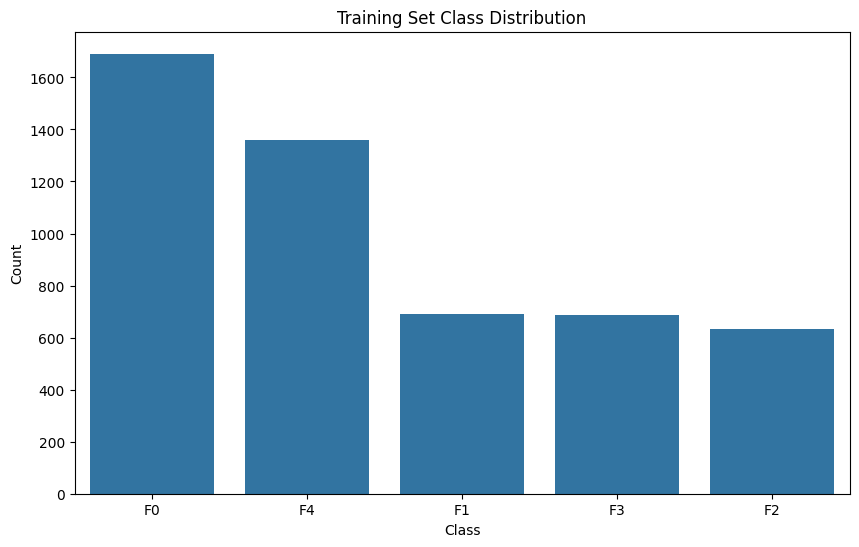

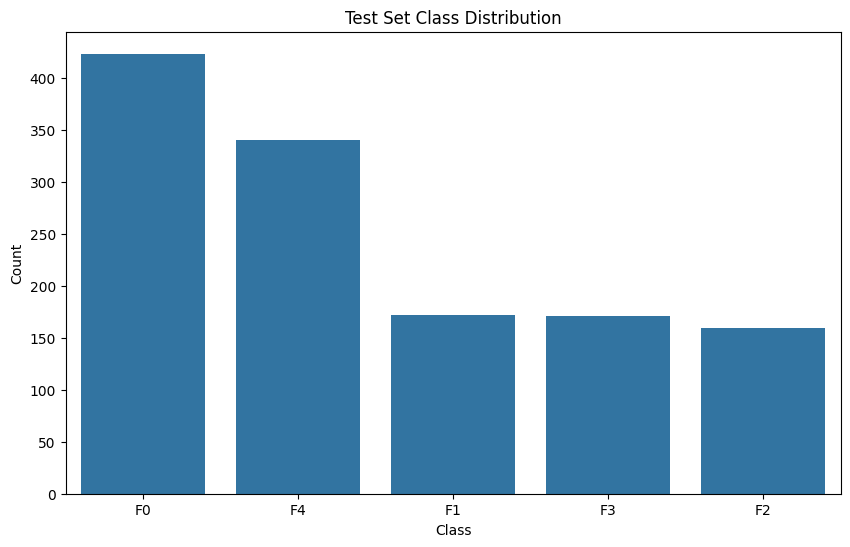

In [7]:

image_folder = os.path.join(path, 'Dataset', 'Dataset')

class_labels = ['F0', 'F1', 'F2', 'F3', 'F4']

image_paths = []
labels = []

for label in class_labels:
    class_folder = os.path.join(image_folder, label)
    for img_name in os.listdir(class_folder):
        image_paths.append(os.path.join(class_folder, img_name))
        labels.append(label)

data = pd.DataFrame({'Image_Path': image_paths, 'Label': labels})

train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['Label'], random_state=42)

print(f"Total images: {len(data)}")
print(f"Training set: {len(train_data)} images")
print(f"Test set: {len(test_data)} images")

def plot_class_distribution(data, title):
    class_counts = data['Label'].value_counts().reset_index()
    class_counts.columns = ['Class', 'Count']
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Class', y='Count', data=class_counts)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

plot_class_distribution(train_data, "Training Set Class Distribution")
plot_class_distribution(test_data, "Test Set Class Distribution")

In [2]:
train_data

,Image_Path,Label
4676,/kaggle/input/liver-histopathology-fibrosis-ul...,F4
5258,/kaggle/input/liver-histopathology-fibrosis-ul...,F4
661,/kaggle/input/liver-histopathology-fibrosis-ul...,F0
932,/kaggle/input/liver-histopathology-fibrosis-ul...,F0
759,/kaggle/input/liver-histopathology-fibrosis-ul...,F0
...,...,...
2638,/kaggle/input/liver-histopathology-fibrosis-ul...,F1
3339,/kaggle/input/liver-histopathology-fibrosis-ul...,F2
799,/kaggle/input/liver-histopathology-fibrosis-ul...,F0
2353,/kaggle/input/liver-histopathology-fibrosis-ul...,F1


In [ ]:
from PIL import Image
import numpy as np

image_path = "/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/F1/h2767.jpg"

image = Image.open(image_path)

image_array = np.array(image)

height, width = image_array.shape[:2]  
channels = 1 if len(image_array.shape) == 2 else image_array.shape[2]  

print(f"Image dimensions: {width}x{height}")
print(f"Number of channels: {channels}")

Image dimensions: 640x480
Number of channels: 1


# Training with no augmentation

In [4]:
from PIL import Image
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.utils import to_categorical

2025-08-25 14:24:08.524475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756131848.695413      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756131848.750642      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import os
import numpy as np
from PIL import Image

def load_images_and_labels_from_dataframe(dataframe, image_size=(224, 224)):
    images = []
    labels = []
    class_names = sorted(dataframe['Label'].unique())
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}

    for _, row in dataframe.iterrows():
        img_path = row['Image_Path']
        label = row['Label']
        img = Image.open(img_path)

        if img.mode != 'RGB':
            img = img.convert('RGB')

        img = img.resize(image_size)
        img_array = np.array(img)

        images.append(img_array)
        labels.append(class_indices[label])

    return np.array(images), np.array(labels), class_indices

image_size = (224, 224)  
X_train, y_train, class_indices = load_images_and_labels_from_dataframe(train_data, image_size=image_size)
X_val, y_val, _ = load_images_and_labels_from_dataframe(test_data, image_size=image_size)

num_classes = len(class_indices)
print(f"Classes: {class_indices}")
print(f"Number of classes: {num_classes}")

Classes: {'F0': 0, 'F1': 1, 'F2': 2, 'F3': 3, 'F4': 4}
Number of classes: 5


In [6]:
X_train.shape
y_train.shape

(5058,)

# testing my own model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input, GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Multiply, Concatenate, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.layers import Lambda

def cbam_block(inputs, reduction_ratio=16):
    channel = inputs.shape[-1]

    avg_pool = GlobalAveragePooling2D()(inputs)
    max_pool = GlobalMaxPooling2D()(inputs)

    avg_pool = Dense(channel // reduction_ratio, activation='relu')(avg_pool)
    avg_pool = Dense(channel, activation='sigmoid')(avg_pool)

    max_pool = Dense(channel // reduction_ratio, activation='relu')(max_pool)
    max_pool = Dense(channel, activation='sigmoid')(max_pool)

    channel_attention = tf.keras.layers.Add()([avg_pool, max_pool])
    channel_attention = Activation('sigmoid')(channel_attention)

    channel_attention = Reshape((1, 1, channel))(channel_attention)
    x = Multiply()([inputs, channel_attention])

    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(x)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(x)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])

    spatial_attention = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    x = Multiply()([x, spatial_attention])

    return x

In [ ]:
def build_cbam_vgg16(input_shape=(224, 224, 3), num_classes=10):
    inputs = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3,3), padding='same', activation='relu')(inputs)
    x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2,2), strides=(2,2))(x)

    # Block 2
    x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2,2), strides=(2,2))(x)

    # Block 3
    x = Conv2D(256, (3,3), padding='same', activation='relu')(x)
    x = Conv2D(256, (3,3), padding='same', activation='relu')(x)
    x = Conv2D(256, (3,3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2,2), strides=(2,2))(x)
    x = cbam_block(x)  

    # Block 4
    x = Conv2D(512, (3,3), padding='same', activation='relu')(x)
    x = Conv2D(512, (3,3), padding='same', activation='relu')(x)
    x = Conv2D(512, (3,3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2,2), strides=(2,2))(x)
    x = cbam_block(x)

    # Block 5
    x = Conv2D(512, (3,3), padding='same', activation='relu')(x)
    x = Conv2D(512, (3,3), padding='same', activation='relu')(x)
    x = Conv2D(512, (3,3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2,2), strides=(2,2))(x)
    x = cbam_block(x)

    # Fully connected layers
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# ====================================
# Residual Bottleneck Block (ResNet50)
# ====================================
def bottleneck_block(x, filters, stride=1, downsample=False):
    shortcut = x

    # 1x1 conv
    x = layers.Conv2D(filters, (1,1), strides=stride, padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # 3x3 conv
    x = layers.Conv2D(filters, (3,3), strides=1, padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # 1x1 conv (expansion)
    x = layers.Conv2D(filters*4, (1,1), strides=1, padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)

    # Downsample shortcut if needed
    if downsample:
        shortcut = layers.Conv2D(filters*4, (1,1), strides=stride, kernel_initializer="he_normal")(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add shortcut
    x = layers.Add()([x, shortcut])
    x = layers.Activation("relu")(x)

    return x


def ResNet50_CBAM(input_shape=(224,224,3), num_classes=2):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, (7,7), strides=2, padding="same", kernel_initializer="he_normal")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((3,3), strides=2, padding="same")(x)

    for i in range(3):
        x = bottleneck_block(x, 64, stride=1, downsample=(i==0))
    x = cbam_block(x)

    for i in range(4):
        x = bottleneck_block(x, 128, stride=(2 if i==0 else 1), downsample=(i==0))
    x = cbam_block(x)

    for i in range(6):
        x = bottleneck_block(x, 256, stride=(2 if i==0 else 1), downsample=(i==0))
    x = cbam_block(x)

    for i in range(3):
        x = bottleneck_block(x, 512, stride=(2 if i==0 else 1), downsample=(i==0))
    x = cbam_block(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    return model


In [ ]:
model = ResNet50_CBAM(input_shape=(224,224,3), num_classes=5)
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-5),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
model.summary()

I0000 00:00:1756131933.492064      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 64)     │          4,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 56, 56, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 56, 56, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 56, 56, 256)    │         16,640 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 256)    │         16,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 56, 56, 256)    │          1,024 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 56, 56, 256)    │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 56, 56, 256)    │              0 │ batch_normalization_3… │
│                           │                        │                │ batch_normalization_4… │
├──────────────────────

 Total params: 24,999,153 (95.36 MB)

 Trainable params: 24,946,033 (95.16 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [12]:
history = model.fit(X_train, y_train,
                           epochs=20,
                           batch_size=5,
                           validation_data=(X_val, y_val),
                           callbacks=[early_stopping])

Epoch 1/20


I0000 00:00:1756131970.645767      59 service.cc:148] XLA service 0x7a6854002650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756131970.646467      59 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756131974.184439      59 cuda_dnn.cc:529] Loaded cuDNN version 90300


   3/1012 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - accuracy: 0.1778 - loss: 1.6578

I0000 00:00:1756131990.297575      59 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1012/1012 ━━━━━━━━━━━━━━━━━━━━ 128s 74ms/step - accuracy: 0.4242 - loss: 1.3422 - val_accuracy: 0.5826 - val_loss: 0.9981
Epoch 2/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 52s 51ms/step - accuracy: 0.5707 - loss: 1.0093 - val_accuracy: 0.6190 - val_loss: 0.8628
Epoch 3/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 52s 51ms/step - accuracy: 0.6080 - loss: 0.9163 - val_accuracy: 0.6419 - val_loss: 0.7967
Epoch 4/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 52s 51ms/step - accuracy: 0.6608 - loss: 0.8189 - val_accuracy: 0.6909 - val_loss: 0.7041
Epoch 5/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 52s 51ms/step - accuracy: 0.6715 - loss: 0.7417 - val_accuracy: 0.7360 - val_loss: 0.5947
Epoch 6/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 52s 51ms/step - accuracy: 0.7359 - loss: 0.6596 - val_accuracy: 0.7573 - val_loss: 0.5733
Epoch 7/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 52s 51ms/step - accuracy: 0.7606 - loss: 0.5877 - val_accuracy: 0.8000 - val_loss: 0.4990
Epoch 8/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 52s 51ms/step - accuracy: 0.7933 - loss: 0.5

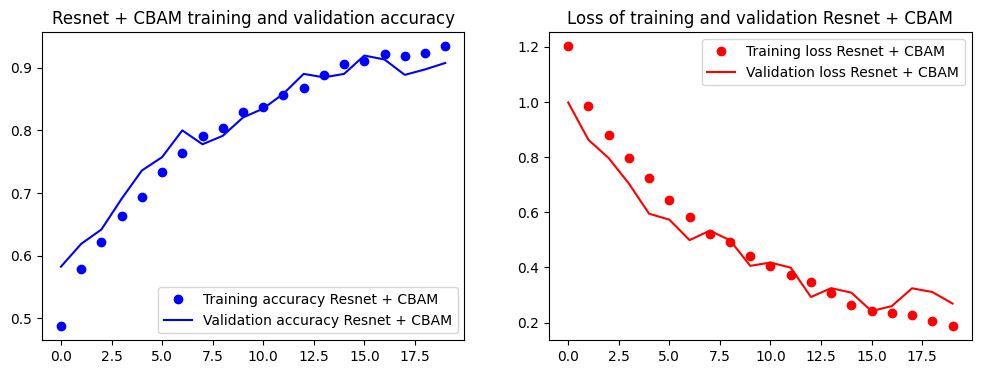

In [13]:
acc_vgg = history.history['accuracy']
val_acc_vgg = history.history['val_accuracy']
loss_vgg = history.history['loss']
val_loss_vgg = history.history['val_loss']
epochs = range(len(acc_vgg))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_vgg, 'bo', label='Training accuracy Resnet + CBAM')
plt.plot(epochs, val_acc_vgg, 'b', label='Validation accuracy Resnet + CBAM')
plt.title('Resnet + CBAM training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss_vgg, 'ro', label='Training loss Resnet + CBAM')
plt.plot(epochs, val_loss_vgg, 'r', label='Validation loss Resnet + CBAM')
plt.title('Loss of training and validation Resnet + CBAM')
plt.legend()

plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 187ms/step


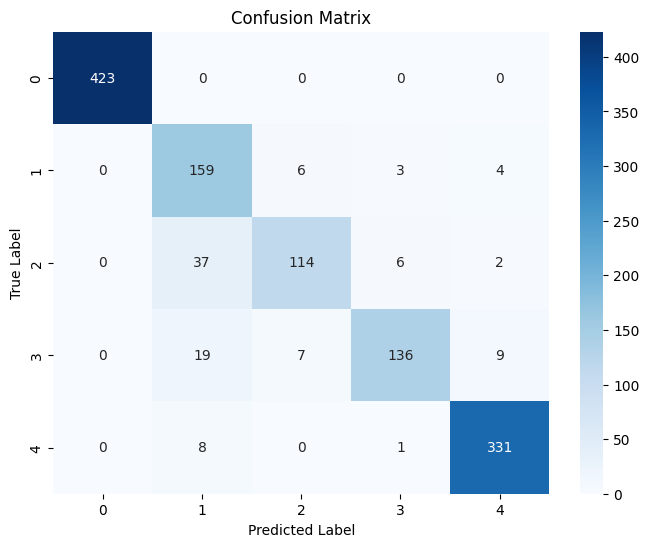

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       423
           1       0.71      0.92      0.81       172
           2       0.90      0.72      0.80       159
           3       0.93      0.80      0.86       171
           4       0.96      0.97      0.97       340

    accuracy                           0.92      1265
   macro avg       0.90      0.88      0.89      1265
weighted avg       0.93      0.92      0.92      1265



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_pred_prob = model.predict(X_val)             
y_pred = np.argmax(y_pred_prob, axis=1)        
y_true = np.argmax(y_val, axis=1) if y_val.ndim > 1 else y_val  

cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred))


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
AUC Score (OVR): 0.9906


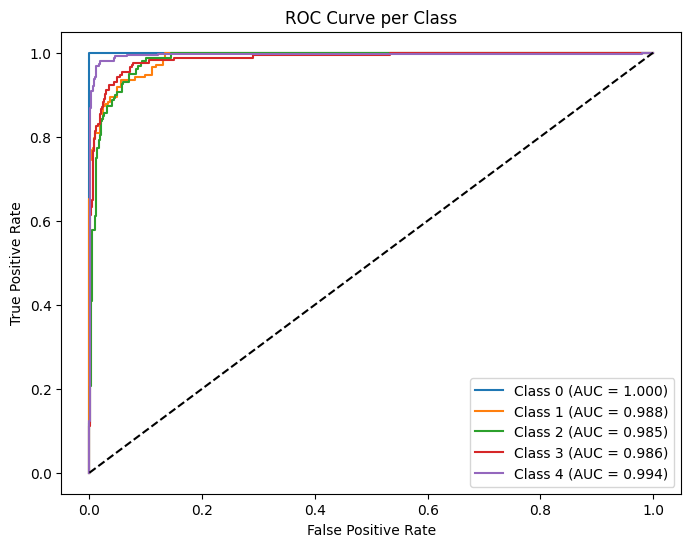

In [15]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_pred_prob = model.predict(X_val)

if y_val.ndim == 1: 
    num_classes = y_pred_prob.shape[1]
    y_val_onehot = np.eye(num_classes)[y_val]
else:
    y_val_onehot = y_val

auc_score = roc_auc_score(y_val_onehot, y_pred_prob, multi_class="ovr")
print(f"AUC Score (OVR): {auc_score:.4f}")

fpr = dict()
tpr = dict()

num_classes = y_pred_prob.shape[1]
plt.figure(figsize=(8,6))

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_onehot[:, i], y_pred_prob[:, i])
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc_score(y_val_onehot[:, i], y_pred_prob[:, i]):.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve per Class")
plt.legend(loc="lower right")
plt.show()


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


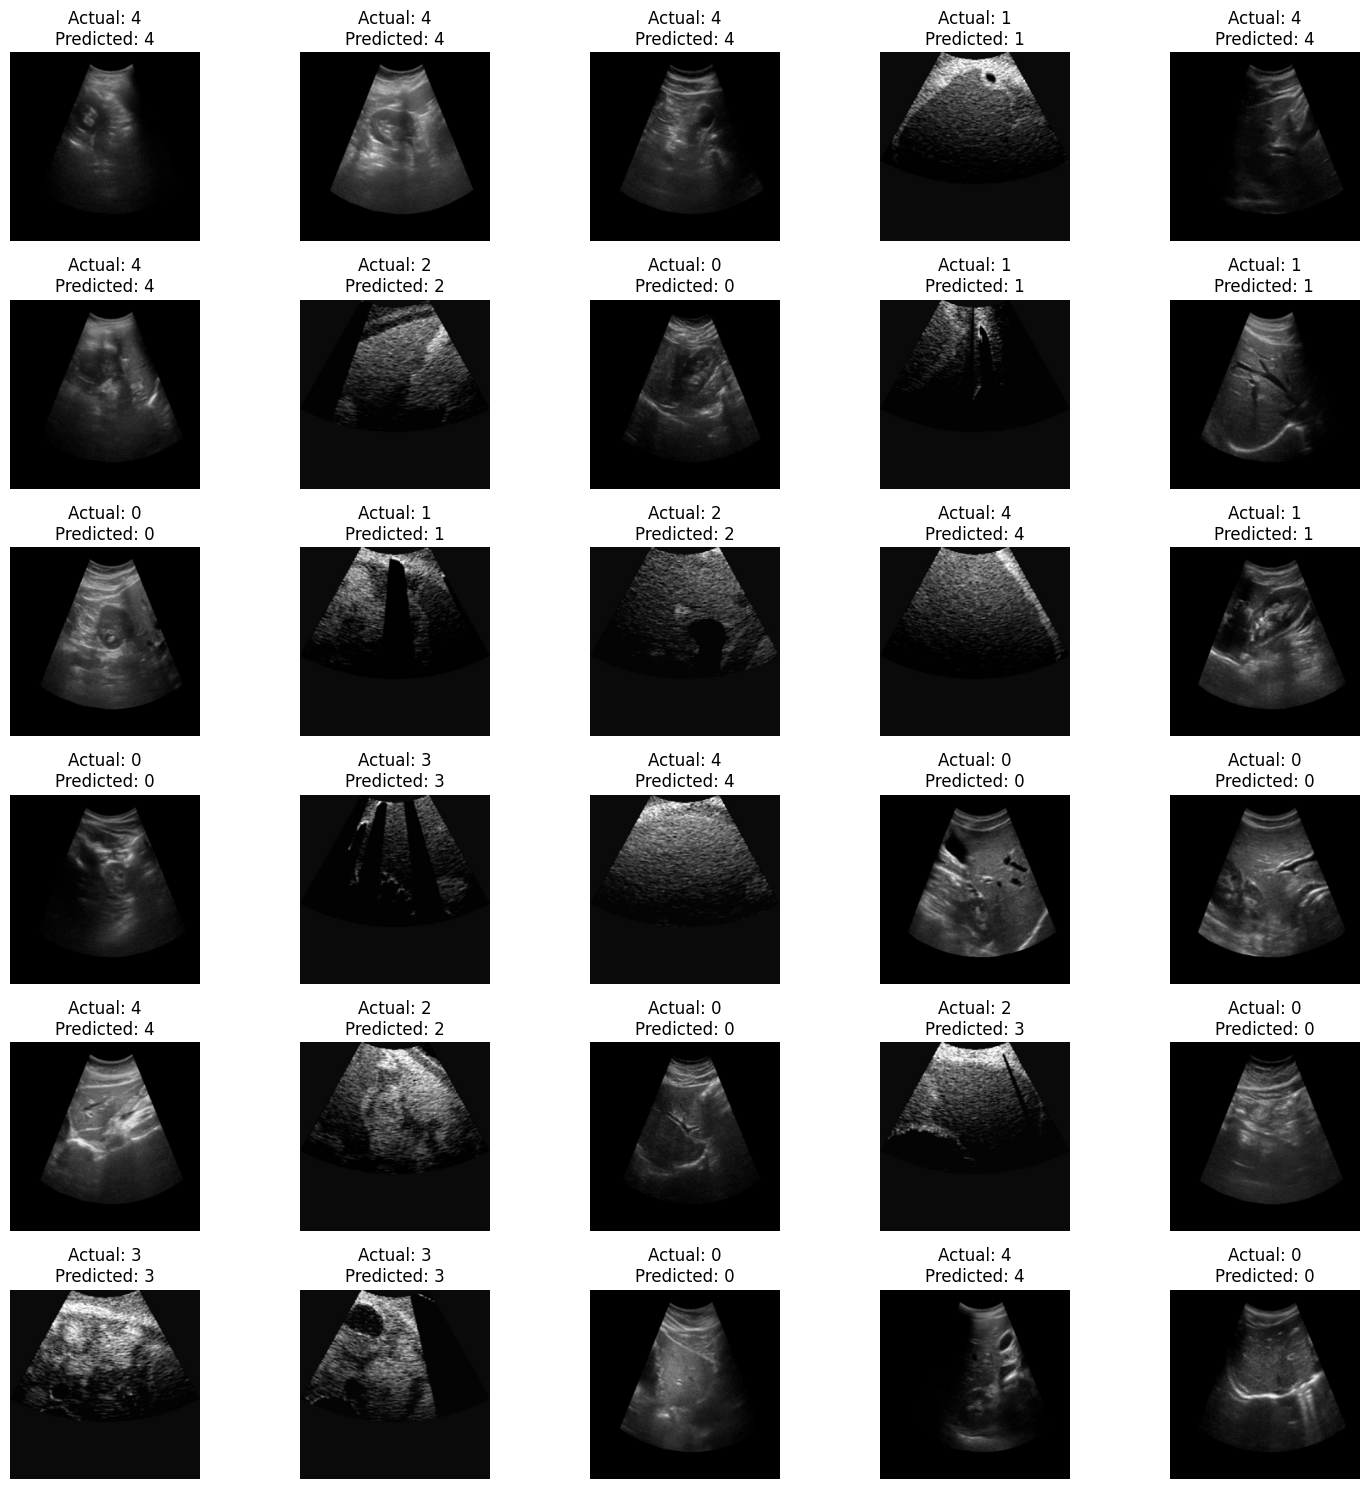

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


y_pred = model.predict(X_val)

y_pred_labels = np.argmax(y_pred, axis=1)

num_images = 30
random_indices = np.random.choice(X_val.shape[0], num_images, replace=False)

plt.figure(figsize=(15, 15))

for i, idx in enumerate(random_indices):
    plt.subplot(6, 5, i+1)  
    img = X_val[idx].squeeze()  
    actual_label = y_val[idx]
    predicted_label = y_pred_labels[idx]

    plt.imshow(img, cmap='gray') 
    plt.axis('off') 

    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")

plt.tight_layout()
plt.show()